In [2]:
import os, time, itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):

        conv1 = tf.layers.conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid')
        lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training=isTrain), 0.2)

        conv2 = tf.layers.conv2d_transpose(lrelu1, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        conv3 = tf.layers.conv2d_transpose(lrelu2, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        conv4 = tf.layers.conv2d_transpose(lrelu3, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        conv5 = tf.layers.conv2d_transpose(lrelu4, 1, [4, 4], strides=(2, 2), padding='same')
        outputs = tf.nn.tanh(conv5)

        return outputs

def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):

        conv1 = tf.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu1 = lrelu(conv1, 0.2)

        conv2 = tf.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        conv3 = tf.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        conv4 = tf.layers.conv2d(lrelu3, 1024, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        conv5 = tf.layers.conv2d(lrelu4, 1, [4, 4], strides=(1, 1), padding='valid')
        outputs = tf.nn.sigmoid(conv5)

        return outputs, conv5

In [4]:
def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

def sampleZ(batch_size):
    return np.random.normal(0, 1, (batch_size, 1, 1, 100))

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

In [5]:
x = tf.placeholder(tf.float32, shape=(None, 64, 64, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
isTrain = tf.placeholder(dtype=tf.bool)
batch_size = 100

In [6]:
G_z = generator(z, isTrain)
D_real, D_real_logits = discriminator(x, isTrain)
D_fake, D_fake_logits = discriminator(G_z, isTrain, reuse=True)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits,
                                                                     labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits,
                                                                     labels=tf.zeros([batch_size, 1, 1, 1])))
D_loss = D_loss_real + D_loss_fake

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits,
                                                                labels=tf.ones([batch_size, 1, 1, 1])))

In [7]:
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

D_solver = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5).minimize(D_loss, var_list=D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5).minimize(G_loss, var_list=G_vars)

In [8]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [9]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])
train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval()
train_set = (train_set - 0.5) / 0.5  # normalization; range: -1 ~ 1

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [10]:
fixed_z_ = np.random.normal(0, 1, (25, 1, 1, 100))
def show_result(num_epoch):
    test_images = sess.run(G_z, {z: fixed_z_, isTrain: False})

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    plt.show()

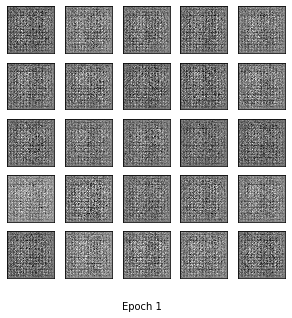

Iter: 0
D loss: 1.608
G_loss: 6.318



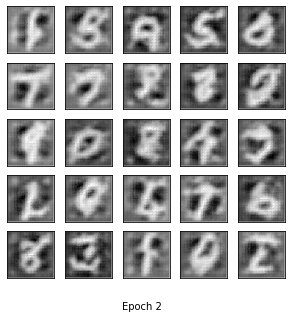

Iter: 1
D loss: 0.5364
G_loss: 4.265



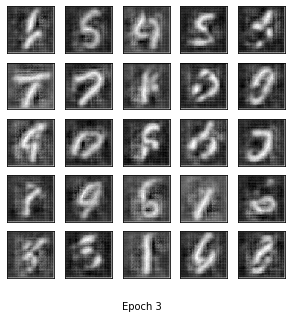

Iter: 2
D loss: 0.0928
G_loss: 3.225



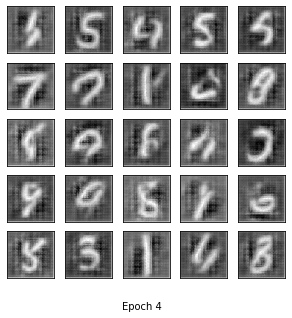

Iter: 3
D loss: 1.87
G_loss: 3.638



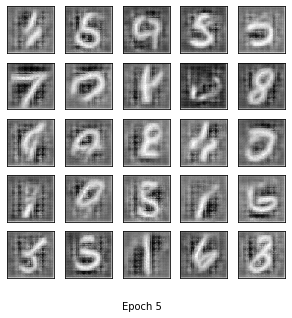

Iter: 4
D loss: 0.0879
G_loss: 3.704



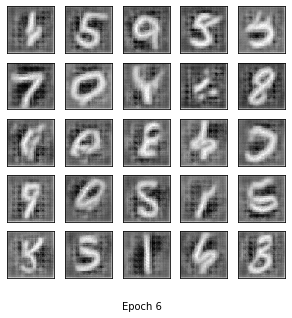

Iter: 5
D loss: 0.0101
G_loss: 6.451



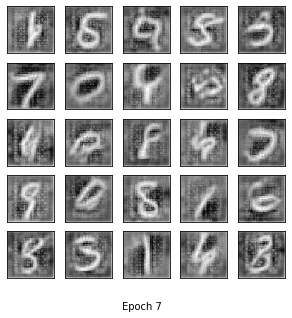

Iter: 6
D loss: 0.378
G_loss: 4.405



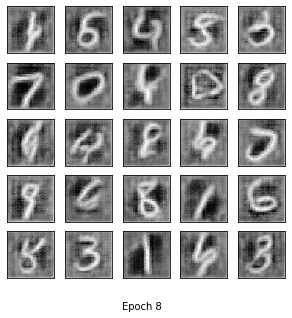

Iter: 7
D loss: 0.1083
G_loss: 4.769



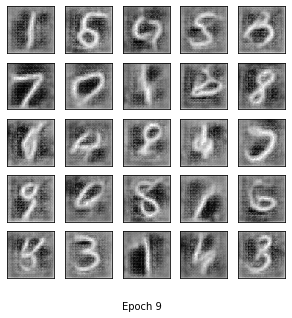

Iter: 8
D loss: 0.001959
G_loss: 8.399



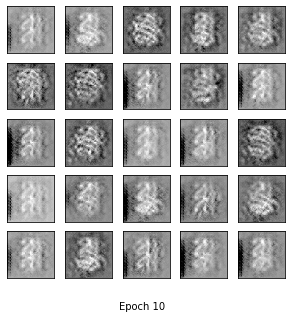

Iter: 9
D loss: 0.2181
G_loss: 25.1



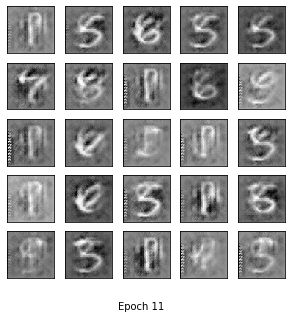

Iter: 10
D loss: 0.2637
G_loss: 4.008



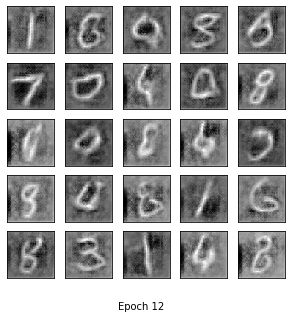

Iter: 11
D loss: 0.003765
G_loss: 6.001



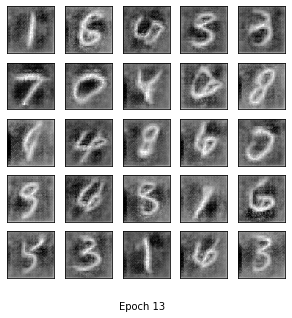

Iter: 12
D loss: 0.005367
G_loss: 7.221



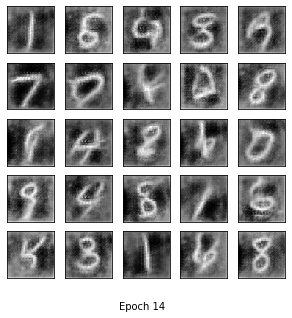

Iter: 13
D loss: 1.012
G_loss: 2.574



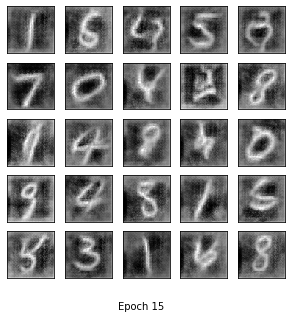

Iter: 14
D loss: 0.6611
G_loss: 5.963



In [11]:
for it in range(15):
    
    show_result((it + 1))
        
    for iter in range(mnist.train.num_examples // 100):

        x_ = train_set[iter*100:(iter+1)*100]

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={x: x_
                                                                 , z: sampleZ(100), isTrain: True})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={z: sampleZ(100), isTrain: True})

    print('Iter: {}'.format(it))
    print('D loss: {:.4}'. format(D_loss_curr))
    print('G_loss: {:.4}'.format(G_loss_curr))
    print()